# Replay Model

In [1]:
from network import Network

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from multiprocessing import Pool

## Set Hyperparameters

In [2]:
# Random seeds
seeds_n = 20
mds_seed = 1

# Number of input items
items_n = 12

# Experiment details
training_blocks = 8
trials = 60
training_length = 2 * training_blocks * trials
stitching_steps = 20

# Network hyperparameters
readouts = 1
h1_size = 20

w1_weight_std = 0.025 * np.sqrt(1 / items_n)
w2_weight_std = np.sqrt(1 / h1_size)

learning_rate = 0.05

modes = [
    "ordered_replay", "ordered_replay_include_boundary",
    "random_full_replay", "random_full_replay_include_boundary", 
    "random_replay", "random_replay_include_boundary", 
    "highest_loss_replay", "highest_loss_replay_include_boundary"
]

## Train Networks

In [3]:
def evaluate(model):
    with torch.no_grad():
        accuracy = 0.
        tests_n = 0
        for item_1 in range(items_n):
            for item_2 in range(items_n):
                if item_1 == item_2:
                    continue
                target = torch.tensor([1. if item_1 > item_2 else -1.])
                _, output = model(item_1, item_2)
                accuracy += (torch.sign(output) == torch.sign(target)).float().item()
                tests_n += 1
        return accuracy / tests_n

In [4]:
def train_networks(seed, replay_epochs, mode, replay_learning_rate=None):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Init Network
    model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, readouts=readouts)
    criterion = torch.nn.MSELoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    training_step = 0
    items_per_context = items_n // 2
    accuracy = np.zeros(stitching_steps + 1)

    for block in range(training_blocks):
        training_pairs = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
        for context in range(2):
            training_pairs += context * items_per_context
            for trial in range(trials):
                # Sample input and target
                random_index = np.random.randint(0, len(training_pairs))
                item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                target = torch.tensor([1. if item_1 > item_2 else -1.])

                # Forward propagate and backpropagate
                optimiser.zero_grad()
                _, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                optimiser.step()

                training_step += 1
    
    training_pairs = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
    stitching_pairs = np.asarray([[items_per_context - 1, items_per_context]])
    replay_pairs = np.concatenate([training_pairs, training_pairs + items_per_context])
    all_pairs = np.concatenate([training_pairs, stitching_pairs, training_pairs + items_per_context])

    accuracy[0] = evaluate(model)
    
    # Stitching
    for stitching_step in range(stitching_steps):
        # Select items from boundary condition
        item_1, item_2 = np.random.choice([(items_n // 2) - 1, (items_n // 2)], 2, replace=False)
        target = torch.tensor([1. if item_1 > item_2 else -1.])

        # Forward propagate and backpropagate
        optimiser.zero_grad()
        h1, output = model(item_1, item_2)
        model.loss = criterion(output, target)
        model.loss.backward()
        optimiser.step()
        
        # Replay
        for replay_step in range(replay_epochs):
            if "include_boundary" in mode:
                pairs = all_pairs
            else:
                pairs = replay_pairs

            if mode == "random_full_replay" or mode == "random_full_replay_include_boundary":
                rdx = np.random.choice(len(pairs), len(pairs), replace=False)
                pairs = pairs[rdx]

            if mode == "random_replay" or mode == "random_replay_include_boundary":
                rdx = np.random.choice(len(pairs), len(pairs), replace=True)
                pairs = pairs[rdx]

            for replay_pair in pairs:
                # Adjust learning rate
                if replay_learning_rate:
                    for g in optimiser.param_groups:
                        g['lr'] = replay_learning_rate

                if mode == "highest_loss_replay" or mode == "highest_loss_replay_include_boundary":
                    with torch.no_grad():
                        losses = []
                        for (item_1, item_2) in pairs:
                            target = torch.tensor([1. if item_1 > item_2 else -1.])
                            optimiser.zero_grad()
                            _, output = model(item_1, item_2)
                            losses.append(criterion(output, target).item())
                        replay_pair = pairs[np.argmax(losses)]

                item_1, item_2 = np.random.choice(replay_pair, 2, False)
                target = torch.tensor([1. if item_1 > item_2 else -1.])

                optimiser.zero_grad()
                h1, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                optimiser.step()
        
        # Re-adjust learning rate
        for g in optimiser.param_groups:
            g['lr'] = learning_rate
        
        accuracy[stitching_step + 1] = evaluate(model)
    
    return accuracy

In [5]:
replay_epochs = [0, 1, 2, 4, 8, 16, 32]

all_accuracies = {mode: {} for mode in modes}
for i, mode in enumerate(modes):
    for replay_epoch in replay_epochs:
        train_networks_ = partial(train_networks, replay_epochs=replay_epoch, mode=mode)
        with Pool(20) as p:
            results = np.asarray(p.map(train_networks_, range(seeds_n)))
        all_accuracies[mode][replay_epoch] = results
    print("Progress", np.round((i+1) / len(modes) * 100, 2), "%", end="\r")

### Plot Results

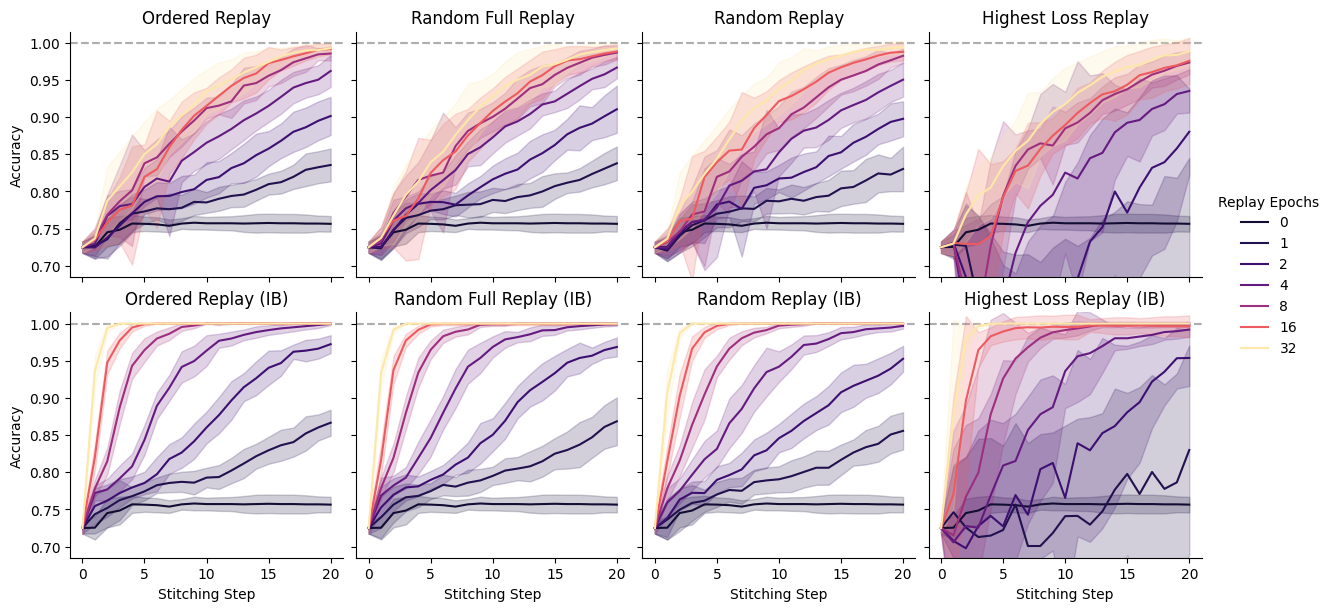

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)

axs = axs.T.flatten()
for i, mode in enumerate(modes):
    accuracies = all_accuracies[mode]
    for n, replay_epoch in  enumerate(replay_epochs):
        color = plt.cm.magma((np.logspace(0, 1., 7) / 10.5)[n])
        mean = np.mean(accuracies[replay_epoch], axis=0)
        std = np.std(accuracies[replay_epoch], axis=0)
        label = replay_epoch if i == 0 else ""
        axs[i].plot(mean, label=label, color=color, zorder=2)
        axs[i].fill_between(range(stitching_steps + 1), mean - std, mean + std, color=color, alpha=0.2, zorder=1)
        axs[i].axhline(1., linestyle="--", c="k", alpha=0.05, zorder = 0)
        
        axs[i].set_ylim(0.685, 1.015)
        axs[i].set_title(mode.replace("_", " ").title().replace("Include Boundary", "(IB)"))
        
        if i in [0, 1]:
            axs[i].set_ylabel("Accuracy")
        if i % 2 == 1:
            axs[i].set_xlabel("Stitching Step")

fig.legend(title="Replay Epochs", loc='center left', frameon=False, bbox_to_anchor=(1, 0.55))
sns.despine()

## Optimise replay learning rate

In [7]:
replay_learning_rates = [0.2, 0.1, 0.05, 0.025, 0.0125]

all_accuracies = {mode: {} for mode in modes}
for i, mode in enumerate(modes):
    for replay_learning_rate in replay_learning_rates:
        train_networks_ = partial(train_networks, replay_epochs=4, mode=mode, 
                                  replay_learning_rate=replay_learning_rate)
        with Pool(20) as p:
            results = np.asarray(p.map(train_networks_, range(seeds_n)))
        all_accuracies[mode][replay_learning_rate] = results
    print("Progress", np.round((i+1) / len(modes) * 100, 2), "%", end="\r")

### Plot Results

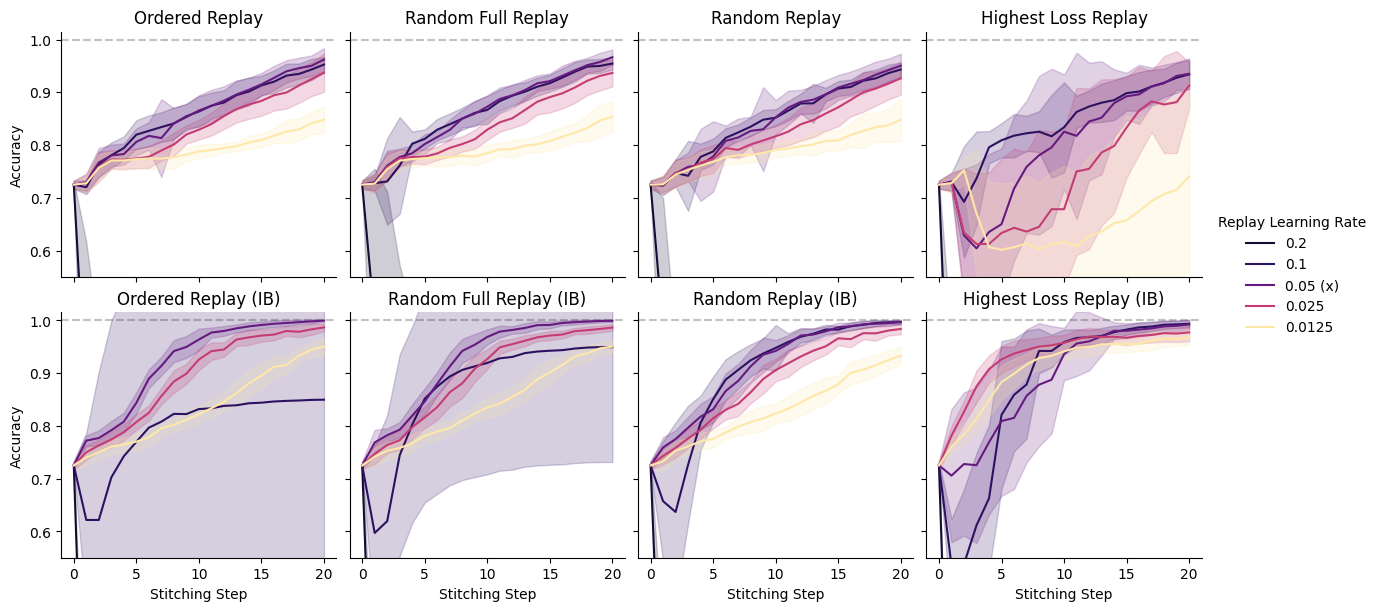

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)

axs = axs.T.flatten()
for i, mode in enumerate(modes):
    accuracies = all_accuracies[mode]
    for n, replay_lr in  enumerate(replay_learning_rates):
        color = plt.cm.magma((np.logspace(0, 1., 5) / 10.5)[n])
        mean = np.mean(accuracies[replay_lr], axis=0)
        std = np.std(accuracies[replay_lr], axis=0)
        label = replay_lr if i == 0 else ""
        if label == 0.05:
            label = str(replay_lr) + " (x)"
        axs[i].plot(mean, label=label, color=color, zorder=2)
        axs[i].fill_between(range(stitching_steps+1), mean - std, mean + std, color=color, alpha=0.2, zorder=1)
        axs[i].axhline(1., linestyle="--", c="k", alpha=0.05, zorder = 0)
        
        axs[i].set_ylim(0.55, 1.015)
        
        axs[i].set_title(mode.replace("_", " ").title().replace("Include Boundary", "(IB)"))
        if i in [0, 1]:
            axs[i].set_ylabel("Accuracy")
        if i % 2 == 1:
            axs[i].set_xlabel("Stitching Step")

fig.legend(title="Replay Learning Rate", loc='center left', frameon=False, bbox_to_anchor=(1, 0.55))
sns.despine()